# 2D Pose Estimation - UNet Architecture

## Based on [Keras Implementation for Biomedical Image Segmentation](https://github.com/zhixuhao/unet)

## Imports 

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import save_model

# Memory Benchmarking
import psutil
process = psutil.Process(os.getpid())

# WandB
import h5py, wandb
from wandb.keras import WandbCallback

In [2]:
# Relative Imports
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from lib import utils, generators, losses
from lib.models.unet_simple import unet_simple

/home/jupyter/thirdeye


## Parameters

In [3]:
# On low RAM, machine, Use Generator for Data Input
# For high RAM machine, Load Full Dataset into RAM
USE_GENERATOR = False

IMAGE_RESOLUTION = 256 # Image Shape (int)

KEYPOINT_RADIUS = 5 # Keypoint Radius for Binary Classification Loss

BATCH_SIZE = 16

NUM_SAMPLES = 128 # Max = 56636, From h5 File
NUM_VAL_SAMPLES = 32 # Max = 2366, From h5 File

EPOCHS = 1

LOSS_TYPE ='bce_logisticloss' # Write str of Loss Function Used

METRICS = ['BinaryAccuracy']

LEARNING_RATE = 'Adam Standard'
DECAY = 'Adam Standard'
OPTIMIZER = Adam()

WANDB = False # Boolean whether or not to log in Weights and Biases
PROJECT_NAME = 'unet-2d-pose'
RUN_NAME = 'classification-1/2data'
NOTES = 'Full Test on 1/2 Dataset'
MODEL = 'UNet'
DATA = 'COCO'

desired_joints = ['left_shoulder',
                  'right_shoulder',
                  'left_elbow',
                  'right_elbow',
                  'left_wrist',
                  'right_wrist',
                  'left_hip',
                  'right_hip',
                  'left_knee',
                  'right_knee',
                  'left_ankle',
                  'right_ankle'
                 ]

VMIN = 0.02 # Colormap Lower Cutoff for Displaying Heatmaps
CMAP = plt.get_cmap('hsv')
CMAP.set_under('k', alpha=0)

### Callbacks

In [4]:
# Callbacks
class Metrics_Callback(Callback):

    def __init__(self, val_data):
        self.validation_data = val_data

    def on_train_begin(self, logs=None):
        self.val_normKPMs = []

    def on_epoch_end(self, epoch, logs=None):

        # Predict Validation Data
        prediction_val = self.model.predict(self.validation_data[0])
        
        # Perform norm_KPM Calculation on Validation Data
        normKPM = losses.normKPM(self.validation_data[1], prediction_val)
        
        print('Total Memory Allocation After KPM: {}'.format(
        process.memory_info().rss/1000000000) ) # in gigabytes 
        
        if WANDB == True:
            wandb.log({'val_normKPMs': normKPM}, step=epoch)
        

### Weights and Biases

In [5]:
if WANDB == True:
    wandb.init(project=PROJECT_NAME,
               notes=NOTES,
               name=RUN_NAME,
               resume=False,
               )
    wandb.config.update({
        "model": MODEL,
        "data": DATA,
        "use_generator": USE_GENERATOR,
        "img_resolution": IMAGE_RESOLUTION,
        "loss": str(LOSS_TYPE),
        "samples": NUM_SAMPLES,
        "val_samples": NUM_VAL_SAMPLES,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "optimizer": str(OPTIMIZER),
        "lr": str(LEARNING_RATE),
        "decay": str(DECAY),
        "keypoint_radius": KEYPOINT_RADIUS,
        })
    wandb_callback = WandbCallback(
            save_model=False,
            monitor='loss',
            mode='auto',
            )

## Load Datasets


In [6]:
# Load h5 File
h5_train_data = h5py.File('../data/coco_train_256_x56637.h5', 'r')
h5_val_data = h5py.File('../data/coco_val_256_x2366.h5', 'r')
print(list(h5_train_data.attrs.keys()))

['jointnames']


#### Sort Desired Joints from h5 Input

In [7]:
# Joints List from h5 Input
input_joints = list(h5_train_data.attrs['jointnames'])

# Create List of Original Input Indices
joint_input_indices = []
for i in input_joints:
    for d in desired_joints:
        if i == d:
            joint_input_indices.append(input_joints.index(i))

print(joint_input_indices)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## Test Data from h5





Finished Creating Generators
Img Batch: (16, 256, 256, 3)
Keypoints Batch: (16, 256, 256, 12)
left_shoulder
Min Val: 0.0
Max Val: 1.0


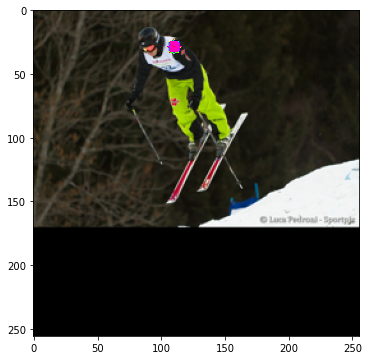

In [8]:
# Create Data Generators
training_generator = generators.h5_generator(h5_train_data, batch_size=BATCH_SIZE,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  keypoint_radius=KEYPOINT_RADIUS)

val_generator = generators.h5_generator(h5_val_data, batch_size=BATCH_SIZE,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  keypoint_radius=KEYPOINT_RADIUS)

print('Finished Creating Generators')

# Get Sample Batch
batch_number = 0
[ batch_x, batch_y ] = training_generator.__getitem__(batch_number)
print('Img Batch: {}'.format(batch_x.shape))
print('Keypoints Batch: {}'.format(batch_y.shape))

# Test Sample Keypoints Heatmap
iteration_number = 0
plt.imshow(batch_x[iteration_number, :, :])

joint_number = 0
print(desired_joints[joint_number])
print('Min Val: {}'.format(np.amin(batch_y[iteration_number, :, :, joint_number])))
print('Max Val: {}'.format(np.amax(batch_y[iteration_number, :, :, joint_number])))
if np.amax(batch_y[iteration_number, :, :, joint_number]) != 0:
    plt.imshow(batch_y[iteration_number, :, :, joint_number], cmap=CMAP, vmin=0.1)
plt.gcf().set_size_inches(6, 6)

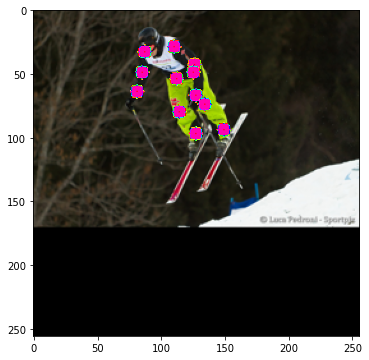

In [9]:
# Overlay all Joints on Original Image
plt.imshow(batch_x[iteration_number, :, :])

for keypoint in range(len(desired_joints)):
  # If Keypoint Exists in image
  if np.amax(batch_y[iteration_number, :, :, keypoint]) != 0:
    plt.imshow(batch_y[iteration_number, :, :, keypoint], cmap=CMAP, vmin=VMIN)
plt.gcf().set_size_inches(6, 6)

## UNet Model

In [10]:
model = unet_simple(input_shape = (IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3), \
                     output_num = len(desired_joints))

model.compile(optimizer = OPTIMIZER, loss = losses.customLoss(), metrics = METRICS)

# Print Full Model Summary
model.summary()

Model: "unet_simple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

## Train Model

In [11]:
if USE_GENERATOR == True:
    # README: If using Generators, KPM Metric cannot be calculated due to insufficient memory.
    # Generators Automatically Use all Memory so Adding Val Data for KPM Metric causes OOM Error.
    
    CALLBACKS = []
    if WANDB == True:
        CALLBACKS.append(wandb_callback)
        
    print('BEFORE TRAINING: {}'.format(process.memory_info().rss/1000000000) ) # in gigabytes 
    
    model.fit_generator(
                        generator=training_generator,
                        steps_per_epoch=int(NUM_SAMPLES/BATCH_SIZE),
                        validation_data=val_generator,
                        validation_freq=1,
                        validation_steps=int(NUM_VAL_SAMPLES/BATCH_SIZE),
                        epochs=EPOCHS,
                        callbacks=CALLBACKS,
                        )

elif USE_GENERATOR == False:
    # README: Memory Allocation: 128 Samples w/ 12 Joints = 7 GB Memory Used
    #                          : 1000 Samples w/ 12 Joints = 25 GB
    #                          : 10,000 Samples w/ 12 Joints = x GB
    #                          : 50,000 Samples w/ 12 Joints = ~=400 GB
    
    # Use Generator to Load All Data into Tensors
    training_generator = generators.h5_generator(h5_train_data, batch_size=NUM_SAMPLES,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  keypoint_radius=KEYPOINT_RADIUS)
    [ img_train_tensor, keypoints_train_tensor ] = training_generator.__getitem__(0)
    
    val_generator = generators.h5_generator(h5_val_data, batch_size=NUM_VAL_SAMPLES,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  keypoint_radius=KEYPOINT_RADIUS)
    [ img_val_tensor, keypoints_val_tensor ] = val_generator.__getitem__(0)
    
    CALLBACKS = [Metrics_Callback(val_data=[ img_val_tensor, keypoints_val_tensor ])]
    if WANDB == True:
        CALLBACKS.append(wandb_callback)
        
    print('Total Memory Allocation Before Training: {}'.format(
        process.memory_info().rss/1000000000) ) # in gigabytes 
    
    # Train Model
    model.fit(x=img_train_tensor, y=keypoints_train_tensor, batch_size=BATCH_SIZE, 
              epochs=EPOCHS, callbacks=CALLBACKS,
              validation_data=[img_val_tensor, keypoints_val_tensor],
              shuffle=True,
             )

Total Memory Allocation Before Training: 3.058438144
Train on 128 samples, validate on 32 samples
128/128 [==============================] - 454s 4s/sample - loss: 8.1205 - BinaryAccuracy: 0.8260 - val_loss: 0.1343 - val_BinaryAccuracy: 0.9954


# Prediction

### Choose Image

1/1 [==============================] - 1s 1s/sample
Norm KPM Value for Prediction: 60.57372312450732
--Joint 1--
Min Val: 3.1111849239096045e-06
Max Val: 0.49735894799232483
--Joint 2--
Min Val: 3.2331659837987664e-23
Max Val: 0.48930513858795166


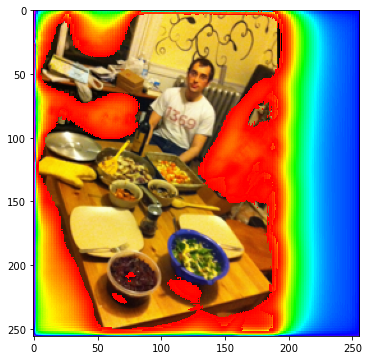

In [16]:
# Get Random Index in h5 File
pred_generator = generators.h5_generator(h5_val_data, batch_size=1,
                                  joint_input_indices=joint_input_indices,
                                  image_resolution=IMAGE_RESOLUTION, 
                                  keypoint_radius=KEYPOINT_RADIUS)
[ pred_img_tensor, pred_keypoints_tensor ] = pred_generator.__getitem__(0)

# Predict Image Joints from Sample
predictions = model.predict(pred_img_tensor, verbose=1)

# Print normKPM Metric
normKPM_value = losses.normKPM(pred_keypoints_tensor, predictions)
print('Norm KPM Value for Prediction: {}'.format(normKPM_value))

# Retrieve Index from Image Tensor
pred_img = pred_img_tensor[0,:]
# Get Corresponding Keypoints
pred_heatmaps = predictions[0,:]

# Overlay all Joints on Original Image
plt.imshow(pred_img)

for keypoint in range(len(desired_joints)):
    # If Keypoint Exists in image
    if np.amax(pred_heatmaps[:, :, keypoint]) != 0:
        plt.imshow(pred_heatmaps[:, :, keypoint], cmap=CMAP, vmin=VMIN)
    
plt.gcf().set_size_inches(6, 6)
    
# Print Prediction Array Stats
# for joint in range(len(desired_joints)):
for joint in range(2):
    print('--Joint {}--'.format(joint+1))
    print('Min Val: {}'.format(np.amin(predictions[0, :, :, joint])))
    print('Max Val: {}'.format(np.amax(predictions[0, :, :, joint])))

if WANDB == True:
    wandb.log({"Full Heatmap": plt})

left_shoulder


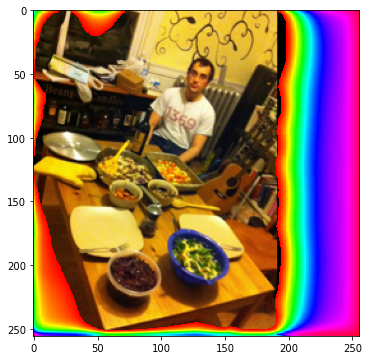

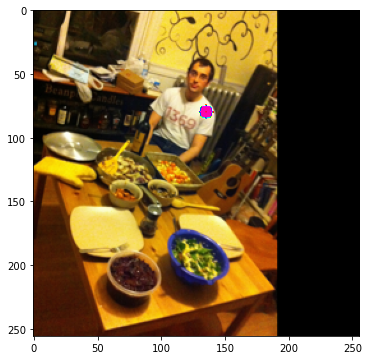

In [17]:
# Choose Joint
joint = 0
print(desired_joints[joint])

plt.imshow(pred_img)

# HeatMap
if np.amax(pred_heatmaps[:, :, keypoint]) != 0:
    plt.imshow(predictions[0, :, :, joint], cmap=CMAP, vmin=VMIN)
else:
    print('Heatmap Plot Error: Max Value in Prediction is {}'.format(np.amax(predictions[0, :, :, joint])))
    print('Heatmap Error: in Prediction is {}'.format(np.amin(predictions[0, :, :, joint])))
plt.gcf().set_size_inches(6, 6)

# Display True Keypoints
plt.figure()
plt.imshow(pred_img)
if np.amax(pred_keypoints_tensor[0, :, :, joint]) != 0:
    plt.imshow(pred_keypoints_tensor[0, :, :, joint], cmap=CMAP, vmin=VMIN)
plt.gcf().set_size_inches(6, 6)

# Save Model

In [ ]:
# Export TF SavedModel
save_model(
    model, ('../SavedModels/' + PROJECT_NAME + '/' + RUN_NAME), overwrite=True, include_optimizer=True,
    signatures=None, options=None
)

In [ ]:
# Copy SavedModel to GCS in Terminal (Ingored from Git)
# Copy to Bucket (Project: thirdeye) /models-thirdeye/unet-2d-pose/model_name